In [1]:
!pip install opendatasets timm lightning --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 65.8 MB/s eta 0:00:00


## Download the dataset from kaggle

In [2]:
import opendatasets as od

# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data'
od.download(dataset)

100%|██████████| 2.29G/2.29G [00:18<00:00, 131MB/s]


## Import the necessary libraries

In [12]:
# custom modules
%load_ext autoreload
%autoreload 2
import utilities
import model_functions
import model_factory

#lightning modules and callbacks
import lightning_data
import lightning_model
import train_info
import learning_curves
import confusion_matrix

import os

# timm models
import timm

# torch modules (temporarily)
import torch.nn as nn
import torch
# pytorch lightning (for checkpointing callbacks)
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Mount GDrive partition to store checkpoints

In [4]:
# necessary, as checkpoints will be saved on GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Create the model to be trained with Pytorch Lightning

In [13]:
# specify here the model configuration
arch_name = 'efficientnet_b0'
classifier_name = 'linear'
classifier_type = model_factory.get_linear_classifer if classifier_name == 'linear' else model_factory.get_simple_non_linear_classifier
layers_version = 'classifier'
n_epochs = 10

# create the model
model, config = model_factory.get_model(arch_name, classifier_type, layers_version, n_epochs=n_epochs)

# set checkpoint path for this specific model configuration
# so that each model will be saved in a different folder
checkpoint_path = os.path.join('/content/drive/MyDrive/model_checkpoints/', arch_name, classifier_name, layers_version)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

4,010,110 total parameters.
2,562 trainable parameters.


In [14]:
checkpoint_path

'/content/drive/MyDrive/model_checkpoints/efficientnet_b0/linear/classifier'

## Set up the Pytorch Lightning modules and callbacks

In [15]:
# dataloader
pneumonia_data = lightning_data.PneumoniaDataModule(config)
# lightning module
pneumonia_model = lightning_model.PneumoniaModel(config,model)

# callback to print training info
training_info_callback = train_info.PrintTrainingInfoCallback()
# callback to show learning curves after training is done
learning_curves_callback = learning_curves.PlotLearningCurvesCallback()
# callback to show confusion matrix after test is done
conf_matrix_callback = confusion_matrix.PlotConfusionMatrixCallback()
#callback to track training times
timer = pl.callbacks.Timer()
# store the metrics in a csv format
logger = CSVLogger(save_dir = checkpoint_path, name="logs", version="")

# callback to save the best model found during training
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=checkpoint_path, # checkpoints are saved to GDrive, in case runtime disconnects
    monitor="val_acc",
    mode='max',
    save_top_k=1,
    verbose=True,
    save_last = True, # save last model (to restore in case runtime disconnects)
    enable_version_counter=False
    )

callbacks = [training_info_callback,learning_curves_callback,conf_matrix_callback,checkpoint_callback,timer]

# create the trainer
trainer = pl.Trainer(
        max_epochs=config['n_epochs'],
        log_every_n_steps=1,
        callbacks = callbacks,
        logger = logger
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


CPU cores: 2, Device: cuda, GPU: Tesla T4


## Training

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/drive/MyDrive/model_checkpoints/efficientnet_b0/linear/classifier exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | EfficientNet | 4.0 M 
1 | criterion | NLLLoss      | 0     
-------------------------------------------
2.6 K     Trainable params
4.0 M     Non-trainable params
4.0 M     Total params
16.040    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 37: 'val_acc' reached 58.43373 (best 58.43373), saving model to '/content/drive/MyDrive/model_checkpoints/efficientnet_b0/linear/classifier/epoch=0-step=37.ckpt' as top 1


Epoch: 001
	Train Loss: 0.3930, Train Accuracy: 85.99%
	Val Loss: 0.7166, Val Accuracy: 58.43%
	Elapsed time: 0h 2m 3s, Remaining Time: 0h 18m 25s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 74: 'val_acc' reached 82.93172 (best 82.93172), saving model to '/content/drive/MyDrive/model_checkpoints/efficientnet_b0/linear/classifier/epoch=1-step=74.ckpt' as top 1


Epoch: 002
	Train Loss: 0.2382, Train Accuracy: 91.71%
	Val Loss: 0.4018, Val Accuracy: 82.93%
	Elapsed time: 0h 3m 60s, Remaining Time: 0h 15m 59s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 111: 'val_acc' reached 83.33334 (best 83.33334), saving model to '/content/drive/MyDrive/model_checkpoints/efficientnet_b0/linear/classifier/epoch=2-step=111.ckpt' as top 1


Epoch: 003
	Train Loss: 0.1975, Train Accuracy: 93.22%
	Val Loss: 0.3719, Val Accuracy: 83.33%
	Elapsed time: 0h 5m 59s, Remaining Time: 0h 13m 58s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 148: 'val_acc' reached 87.75101 (best 87.75101), saving model to '/content/drive/MyDrive/model_checkpoints/efficientnet_b0/linear/classifier/epoch=3-step=148.ckpt' as top 1


Epoch: 004
	Train Loss: 0.1864, Train Accuracy: 93.66%
	Val Loss: 0.2960, Val Accuracy: 87.75%
	Elapsed time: 0h 7m 59s, Remaining Time: 0h 11m 58s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 185: 'val_acc' was not in top 1


Epoch: 005
	Train Loss: 0.1705, Train Accuracy: 93.73%
	Val Loss: 0.3364, Val Accuracy: 85.34%
	Elapsed time: 0h 9m 58s, Remaining Time: 0h 9m 58s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 222: 'val_acc' was not in top 1


Epoch: 006
	Train Loss: 0.1680, Train Accuracy: 93.70%
	Val Loss: 0.3182, Val Accuracy: 85.94%
	Elapsed time: 0h 11m 55s, Remaining Time: 0h 7m 57s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 259: 'val_acc' was not in top 1


Epoch: 007
	Train Loss: 0.1649, Train Accuracy: 93.90%
	Val Loss: 0.3127, Val Accuracy: 86.35%
	Elapsed time: 0h 13m 53s, Remaining Time: 0h 5m 57s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 296: 'val_acc' was not in top 1


Epoch: 008
	Train Loss: 0.1619, Train Accuracy: 94.15%
	Val Loss: 0.2964, Val Accuracy: 86.55%
	Elapsed time: 0h 15m 50s, Remaining Time: 0h 3m 58s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 333: 'val_acc' was not in top 1


Epoch: 009
	Train Loss: 0.1553, Train Accuracy: 94.55%
	Val Loss: 0.2978, Val Accuracy: 87.15%
	Elapsed time: 0h 17m 47s, Remaining Time: 0h 1m 59s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 370: 'val_acc' reached 88.55421 (best 88.55421), saving model to '/content/drive/MyDrive/model_checkpoints/efficientnet_b0/linear/classifier/epoch=9-step=370.ckpt' as top 1


Epoch: 010
	Train Loss: 0.1515, Train Accuracy: 94.87%
	Val Loss: 0.2740, Val Accuracy: 88.55%
	Elapsed time: 0h 19m 47s, Remaining Time: 0h 0m 0s


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


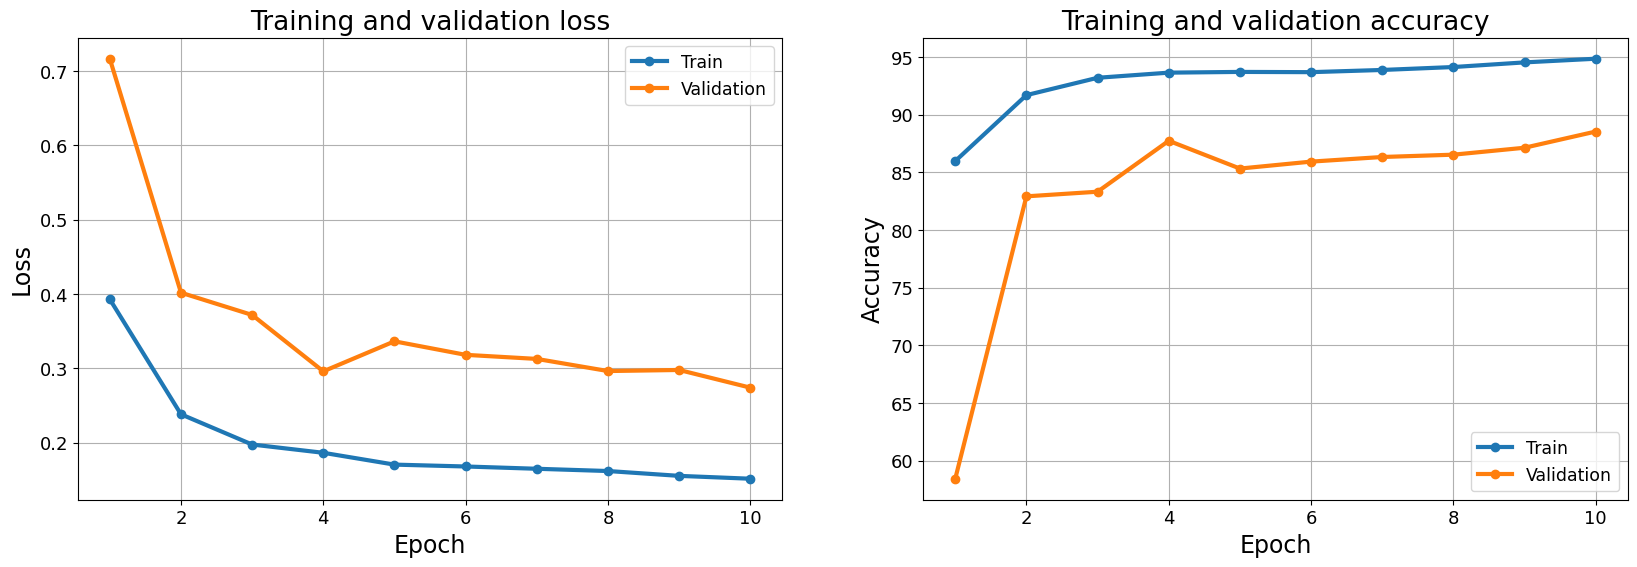

In [16]:
# uncomment this to restore training from last saved checkpoint (in case something went wrong)
#trainer.fit(pneumonia_model, datamodule=pneumonia_data, ckpt_path=checkpoint_path+"/last.ckpt")
trainer.fit(pneumonia_model, datamodule=pneumonia_data)

## Test

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

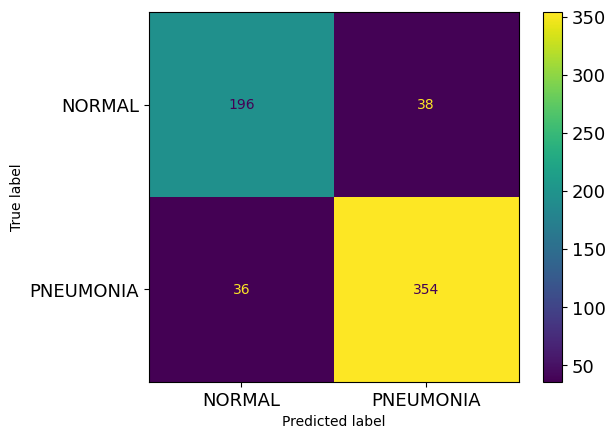

[{}]

In [17]:
# retrieve the best model from checkpoints
best_model_path = checkpoint_callback.best_model_path
best_model = lightning_model.PneumoniaModel.load_from_checkpoint(best_model_path, h=config, model=model)
pneumonia_model = best_model

# test the best model
trainer.test(pneumonia_model, datamodule=pneumonia_data)
#trainer.test(ckpt_path="best", datamodule=pneumonia_data) # alternatively, to test the best model directly

In [18]:
print(f"Test accuracy: {pneumonia_model.test_acc*100:.2f}%")
print(f"Precision: {pneumonia_model.test_precision*100:.2f}%")
print(f"Recall: {pneumonia_model.test_recall*100:.2f}%")
print(f"F1-score: {pneumonia_model.test_f1*100:.2f}%")

Test accuracy: 88.24%
Precision: 90.31%
Recall: 90.77%
F1-score: 90.54%


## Retrieve training loss and accuracy

In [11]:
# to retrieve training info
ckpt = torch.load(checkpoint_path+"/last.ckpt")
#ckpt['callbacks']['PlotLearningCurvesCallback']

In [ ]:
# time elapsed in seconds to 'train' and 'validate'
ckpt['callbacks']['Timer']['time_elapsed']

{'train': 877.5338036420001,
 'sanity_check': 0,
 'validate': 10.822792628999878,
 'test': 0,
 'predict': 0}

## Apply Grad-CAM XAI method

In [ ]:
!pip -q install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#best_model_path = checkpoint_callback.best_model_path # if same session, this will retrieve the path for you
best_model_path = checkpoint_path + "/epoch={}-step={}.ckpt" # replace {} with epoch and step of best model
best_model = lightning_model.PneumoniaModel.load_from_checkpoint(best_model_path, h=config, model=model)
pneumonia_model = best_model

In [ ]:
# extract the model from lightning module
model_lightning = pneumonia_model.model.eval().cpu()
# get the name of the architecture (used later)
model_lightning_name = model_lightning.default_cfg['architecture']

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from PIL import Image

In [ ]:
instance_name = 'xray.jpeg' # name of the image instance we want to explain with Grad-CAM

img = np.array(Image.open(instance_name).convert('RGB'))
img = cv2.resize(img, (config['image_size'], config['image_size']))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=config['mean'], std=config['std'])

In [ ]:
# retrieve the proper feature layer to be used for explanation
if model_lightning_name == 'legacy_xception':
  target_layers = [model_lightning.conv4]
elif model_lightning_name == 'densenet121':
  target_layers = [model_lightning.features.denseblock4.denselayer16]
elif model_lightning_name == 'resnet50':
  target_layers = [model_lightning.layer4[-1]]


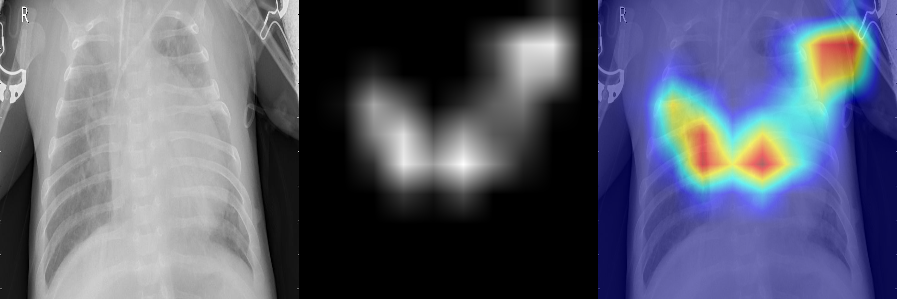

In [ ]:
with GradCAM(model=model_lightning, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor) # activation map generated for the top scoring class
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)